In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import textwrap

In [2]:
reviews = pd.read_csv("redmond_yelp_reviews.csv")
positive_reviews = reviews[reviews.rating>=3]
negative_reviews = reviews[reviews.rating<3]
reviews.head(5)

,id,name,city,state,date,rating,text
0,1,Morgan B.,Bellingham,WA,12/24/2021,5,Amazing Thai food. We had our in office partie...
1,2,Shay C.,Vancouver,WA,12/26/2021,1,Ordered here with Uber Eats on 12/26 when it w...
2,3,Sarah S.,Seattle,WA,7/5/2021,5,"We ordered our usual- the Phad Thai, Phad See ..."
3,4,Michael S.,Carnation,WA,12/6/2021,1,Food was soggy and runny. Portions were large ...
4,5,Mo P.,Camarillo,CA,6/20/2021,5,Delicious food and wonderful service. Both ind...


In [3]:
vec = TfidfVectorizer(max_df=0.95)
positive_vec = TfidfVectorizer(max_df=0.95)
negative_vec = TfidfVectorizer(max_df=0.95)

tf_idf = vec.fit_transform(reviews.text)
positive_tf_idf = positive_vec.fit_transform(positive_reviews.text)
negative_tf_idf = negative_vec.fit_transform(negative_reviews.text)

words = vec.get_feature_names()
positive_words = positive_vec.get_feature_names()
negative_words = negative_vec.get_feature_names()

tf_idf = csr_matrix(tf_idf)
positive_tf_idf = csr_matrix(positive_tf_idf)
negative_tf_idf = csr_matrix(negative_tf_idf)

tf_idf = normalize(tf_idf)
positive_tf_idf = normalize(positive_tf_idf)
negative_tf_idf = normalize(negative_tf_idf)

In [4]:
def initialize_centroids(data,k,seed=None):
    
    if seed is not None:
        np.random.seed(seed)
        
    centroids = np.zeros((k,data.shape[1]))
    num_texts = data.shape[0]
    
    first_centroid_index = np.random.randint(num_texts)
    centroids[0] = data[first_centroid_index,:].toarray()
    
    distances = pairwise_distances(data,[centroids[0]],metric="euclidean").flatten()
    
    for centroid in range(1,k):
        index = np.random.choice(num_texts,1,p=distances/sum(distances))
        centroids[centroid] = data[index,:].toarray()
        distances = pairwise_distances(data,centroids[0:centroid+1],metric="euclidean")
        # Distance to closest clusters
        distances = np.min(distances,axis=1)
    
    return centroids

In [5]:
def assign_clusters(data,centroids):
    
    distances = pairwise_distances(data,centroids,metric="euclidean")
    cluster_assignments = np.argmin(distances,axis=1)
    return cluster_assignments

In [6]:
def update_centroids(data,k,cluster_assignments):
    
    new_centroids = []
    for centroid in range(k):
        new_centroid = data[cluster_assignments==centroid].mean(axis=0)
        new_centroids.append(new_centroid.A1)
        
    new_centroids = np.array(new_centroids)    
    return new_centroids

In [7]:
def calculate_heterogeneity(data,k,centroids,cluster_assignments):
    
    total_heterogeneity = 0.0
    
    for centroid in range(k):
        current_cluster = [centroids[centroid]]
        data_in_current_cluster = data[cluster_assignments==centroid]
        if data_in_current_cluster.shape[0] > 0:
            cluster_differences = pairwise_distances(data_in_current_cluster,current_cluster,metric="euclidean")
            cluster_heterogeneity = np.sum(cluster_differences**2)
            total_heterogeneity = total_heterogeneity + cluster_heterogeneity
        
    return total_heterogeneity
        

In [8]:
def kmeans_plusplus(data,k,max_itr,seed=None,heterogeneities=None,verbose=False):
    
    centroids = initialize_centroids(data,k,seed)
    previous_cluster_assignments = None
    
    for itr in range(max_itr):
        
        if verbose and itr != 0:
            print("Iteration:",itr)
            
        current_cluster_assignments = assign_clusters(data,centroids)
        centroids = update_centroids(data,k,current_cluster_assignments)
        
        if (previous_cluster_assignments is not None) and ((previous_cluster_assignments == current_cluster_assignments).all()):
            break
        
        if previous_cluster_assignments is not None:
            num_new_assignments = sum(abs(previous_cluster_assignments-current_cluster_assignments))
            if verbose:
                print("Number of New Assignments:",num_new_assignments)
                print("")
        
        if heterogeneities is not None:
            heterogeneity = calculate_heterogeneity(data,k,centroids,current_cluster_assignments)
            heterogeneities.append(heterogeneity)
            
        previous_cluster_assignments = current_cluster_assignments[:]
        
    return centroids, current_cluster_assignments
            
        

Iteration: 1
Number of New Assignments: 22

Iteration: 2
Number of New Assignments: 20

Iteration: 3
Number of New Assignments: 8

Iteration: 4
Number of New Assignments: 6

Iteration: 5
Number of New Assignments: 3

Iteration: 6
Number of New Assignments: 1

Iteration: 7
Number of New Assignments: 1

Iteration: 8


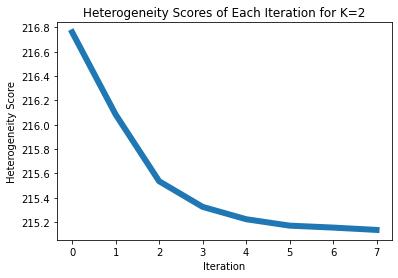

In [9]:
k = 2
heterogeneity_list = []
centroids,cluster_assignments = kmeans_plusplus(tf_idf,k,max_itr=300,heterogeneities=heterogeneity_list,verbose=True)

_ = plt.plot(heterogeneity_list,linewidth=6)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Heterogeneity Score")
_ = plt.title(f"Heterogeneity Scores of Each Iteration for K={k}")

In [10]:
def best_kmeans_plusplus(data,k,max_itr,num_seeds,verbose=False):
    
    min_heterogeneity = np.inf
    final_centroids = None
    final_cluster_assignments = None
    
    seeds = np.random.randint(0,1000,size=num_seeds)
    
    for seed in seeds:
        current_centroids,current_cluster_assignments = kmeans_plusplus(data,k,max_itr,seed,None,False)
        current_heterogeneity = calculate_heterogeneity(data,k,current_centroids,current_cluster_assignments)
        
        if verbose:
            print("Seed:",seed,"     Heterogeneity:",current_heterogeneity)
            
        if current_heterogeneity < min_heterogeneity:
            min_heterogeneity = current_heterogeneity
            final_centroids = current_centroids
            final_cluster_assignments = current_cluster_assignments
    
    if verbose:
        print("")
        print("Lowest Heterogeneity Score:",min_heterogeneity)
        print("")
        
    return final_centroids, final_cluster_assignments 
    

In [19]:
def get_clusters_preview(data,tf_idf,centroids,cluster_assignments,k,words,num_words_displayed,num_reviews_displayed):
    
    for cluster in range(k):
        print("Cluster",cluster+1)
        print("")
        
        top_words_index = centroids[cluster].argsort()[::-1]
        print("Top",num_words_displayed,"Words:")
        for word_i in range(num_words_displayed):
            word = words[top_words_index[word_i]]
            print(word,end=" ")
    
        distances = pairwise_distances(tf_idf,[centroids[cluster]],metric="euclidean").flatten()
        distances[cluster_assignments!=cluster] = np.inf
        distances = distances.argsort()
        
        for review_i in range(num_reviews_displayed):
            review = data.iloc[distances[review_i]]
            name = review['name']
            rating = review['rating']
            date = review['date']
            text = review['text']
            print()
            print()
            print(name + " (" + str(rating) + " Star Rating" +" as of " + str(date) + ")") 
            print(textwrap.fill(text,150))
            
        print("-"*200)

In [20]:
def get_clusters_info(data,tf_idf,centroids,cluster_assignments,k,words,num_words_displayed):
    
    for cluster in range(k):
        print("Cluster",cluster+1)
        print("")
        
        top_words_index = centroids[cluster].argsort()[::-1]
        print("Top",num_words_displayed,"Words:")
        for word_i in range(num_words_displayed):
            word = words[top_words_index[word_i]]
            print(word,end=" ")
    
        distances = pairwise_distances(tf_idf,[centroids[cluster]],metric="euclidean").flatten()
        distances[cluster_assignments!=cluster] = np.inf
        distances = distances.argsort()
        
        num_reviews_in_cluster = len(data[cluster_assignments==cluster])
        
        for review_i in range(num_reviews_in_cluster):
            review = data.iloc[distances[review_i]]
            name = review['name']
            rating = review['rating']
            date = review['date']
            text = review['text']
            print()
            print()
            print(name + " (" + str(rating) + " Star Rating" +" as of " + str(date) + ")") 
            print(textwrap.fill(text,150))
            
        print("-"*200)

In [22]:
## ALL REVIEWS

k = 4
centroids,cluster_assignments = best_kmeans_plusplus(tf_idf,k,max_itr=300,num_seeds=10,verbose=False)
get_clusters_preview(reviews,tf_idf,centroids,cluster_assignments,k,words,20,3)

Cluster 1

Top 20 Words:
friendly and is reasonably priced nice good always love restaurant fan sleek staff this the food sauce not rating have 

Jeremy C. (5 Star Rating as of 7/11/2020)
Love this place. The staff is always friendly and attentive. The food is also good and reasonably priced.


Cheri B. (5 Star Rating as of 11/11/2010)
Love this restaurant for Thai!  Yummy and reasonably priced.  Staff very friendly.


Linda K. (4 Star Rating as of 3/27/2010)
The food here is consistently good, love the soups and duck curry.  Service is good, friendly waitstaff.  Some evenings there is a piano player.
 Normally, I'm not a fan but it works here and it's a nice touch.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 2

Top 20 Words:
the was and to we it in of but were food had my for with that not thai they have 

Jennifer H. (1 S

In [23]:
## POSITIVE REVIEWS

k=2
positive_centroids,positive_cluster_assignments = best_kmeans_plusplus(positive_tf_idf,k,max_itr=300,num_seeds=10,verbose=False)
get_clusters_preview(positive_reviews,positive_tf_idf,positive_centroids,positive_cluster_assignments,k,positive_words,20,3)

Cluster 1

Top 20 Words:
the and to it was is in we thai of my food they for but have with you this are 

Sam H. (4 Star Rating as of 5/22/2006)
Years of search for decent Thai in Redmond and now there's Silver Spoon. I know a lot of people like Typhoon, but I really don't like the Phad Thai
there, which is pretty much a deal breaker for me. I love Thai food, so whenever they open one in Redmond, I try to get there... FAST. So my wife,
toddler son, and I went there last night for dinner instead of cooking. The pics are from my phone, so they are kinda... not good. Anyway, Silver
Spoon is in a strip mall surround by beautiful forests that are quickly being chopped down to make room for more generic houses on Redmond Ridge. It's
a nice looking strip mall, to be sure.The corner of the building has a nice sign, so it's easy to find and the parking is good. When you  walk in the
front door, you're greated by a beautiful large tropical fish tank and several Thai folks in Hawaiian shirts. It'

In [24]:
## NEGATIVE REVIEWS

k=2
negative_centroids,negative_cluster_assignments = best_kmeans_plusplus(negative_tf_idf,k,max_itr=300,num_seeds=10,verbose=False)
get_clusters_preview(negative_reviews,negative_tf_idf,negative_centroids,negative_cluster_assignments,k,negative_words,20,3)

Cluster 1

Top 20 Words:
the they to food is me and not you service for was it have are this dont of your years 

V S. (1 Star Rating as of 11/9/2017)
This place provides bad food, and TERRIBLE customer service. I guess the only reason they are still in business is because they are the only thai
place in redmond ridge area. Food - we ordered 3 dishes. they messed up 2 out of the 3 dishes (messed up both the rice dishes). When i called, they
said it is because they mix white and brown rice (what? who asked you to mix it, without even telling your customer). It was a take-out order, and the
only way they would fix it is for me to drive all the way back and show them the food. When i went back, they opened both the boxes, and said either
they can remake it or refund. At this point, i was too exhausted to wait, so asked them to just refund. They had the audacity of refunding me the full
price, and then AGAIN CHARGE me for the one dish that i did not bring back. So much for making me drive 